In [60]:
import time
import matplotlib.pyplot as plt
import random
from sympy import factorint, isprime
from sympy.ntheory import pollard_rho
import statistics
import signal



In [61]:
ORDER_RANGE = (3, 100)
SAMPLES_PER_ORDER = 5
MAX_SECONDS_TO_TEST = 5
MAX_FAILED_ORDERS = 5

In [62]:
class TimeoutException(Exception):   # Custom exception class
    pass

def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException

# Change the behavior of SIGALRM
signal.signal(signal.SIGALRM, timeout_handler)

<function __main__.timeout_handler(signum, frame)>

### Простые версии алгоритмов без таймаутов

In [63]:
def simple_brutforce(n):
    factors = []
    d = 2
    while d * d <= n:
        while n % d == 0:
            factors.append(d)
            n //= d
        d += 1
    if n > 1:
        factors.append(n)
    return factors

In [54]:
def pollard_rho_simple(n):
    """ρ-алгоритм Полларда для поиска делителей"""
    res = dict()
    while True:
        if n <= 1000:
            break
        t = pollard_rho(n)
        if t is None:
            res[n] = res.get(n, 0) + 1
            break
        res[t] = 0
        while n % t == 0:
            n //= t
            res[t] += 1
    return res

In [9]:
def factorint_simple(n):
    """Умный комбинированный метод из SymPy"""
    return factorint(n)


In [10]:
def ecm_factor_simple(n):
    """Метод эллиптических кривых (ECM)"""
    return factorint(n, use_ecm=True)

In [11]:
def qs_factor_simple(n):
    """Метод квадратичного решета (Quadratic Sieve)"""
    # Для QS будем использовать более агрессивные настройки
    try:
        return factorint(n, use_siqs=True, verbose=False)
    except:
        # Если QS не сработал, пробуем обычный factorint
        return factorint(n)

### ------------------------------------------------------

In [64]:
def generate_composite_number(order):
    """Генерация случайного составного числа заданного порядка"""
    lower_bound = 10 ** (order - 1)
    upper_bound = 10 ** order - 1
    
    for _ in range(1000):
        candidate = random.randint(lower_bound, upper_bound)

        # Проверяем, что число составное и не слишком простое
        if not isprime(candidate) and candidate > 1:
            # Дополнительная проверка: число не должно быть степенью маленького простого
            temp = candidate
            for p in [2, 3, 5, 7, 11, 13, 17, 19]:
                while temp % p == 0:
                    temp //= p
            if temp > 1:  # Есть нетривиальные множители
                return candidate

    # Если не удалось, возвращаем гарантированно составное число
    num1 = random.randint(10 ** (order // 2 - 1), 10 ** (order // 2))
    num2 = random.randint(10 ** (order - order // 2 - 1), 10 ** (order - order // 2))
    return num1 * num2

In [38]:
def run_algorithm_simple(algorithm, *args, max_time: int = 20) -> tuple[float,bool]:
    start_time = time.time()
    
    try:
        signal.alarm(max_time)
        algorithm(*args)
    except TimeoutException:
        pass
    finally:
        signal.alarm(0)

    end_time = time.time()
    execution_time = end_time - start_time

    if execution_time > max_time:
        return max_time, False
    else:
        return execution_time, True



In [65]:
ALGORITHMS = {
    "Simple Brutforce": simple_brutforce,
    "Pollard Rho": pollard_rho_simple,
    "Elliptic Curve (ECM)": ecm_factor_simple,
    "Quadratic Sieve (QS)": qs_factor_simple,
    "SymPy factorint": factorint_simple
}

results = {name: [] for name in ALGORITHMS}
max_orders = {name: 0 for name in ALGORITHMS}

In [71]:
def test_algorithm(
    algorithm_name: str,
    orders: tuple[int, int] = ORDER_RANGE,
    samples_per_order = SAMPLES_PER_ORDER,
    max_seconds_to_test: int = MAX_SECONDS_TO_TEST,
    max_failed_orders: int = MAX_FAILED_ORDERS,
):
    print(f"Тестируем алгоритм: {algorithm_name}")
    algorithm = ALGORITHMS[algorithm_name]

    for order in range(orders[0], orders[1]+1):
        print(f"Порядок {order}: ", end="", flush=True)
        order_times = []
        successful_runs = 0
        timeout_count = 0

        for _ in range(samples_per_order):
            test_number = generate_composite_number(order)

            time_taken, success = run_algorithm_simple(
                algorithm,
                test_number,
                max_time=max_seconds_to_test,
            )

            if success and time_taken < max_seconds_to_test:
                order_times.append(time_taken)
                successful_runs += 1
                print("✓", end=" ")
            else:
                order_times.append(max_seconds_to_test)
                timeout_count += 1
                print("✗", end=" ")
        
        if successful_runs > 0:
            avg_time = statistics.mean([t for t in order_times if t < max_seconds_to_test])
            results[algorithm_name].append(avg_time)
            max_orders[algorithm_name] = order
            print(f" | среднее: {avg_time:.3f} сек")
        else:
            break


In [67]:
test_algorithm("Simple Brutforce")


Тестируем алгоритм: Simple Brutforce
Порядок 3: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 4: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 5: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 6: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 7: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 8: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 9: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 10: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 11: ✓ ✓ ✓ ✓ ✓  | среднее: 0.002 сек
Порядок 12: ✓ ✓ ✓ ✓ ✓  | среднее: 0.002 сек
Порядок 13: ✓ ✓ ✓ ✓ ✓  | среднее: 0.012 сек
Порядок 14: ✓ ✓ ✓ ✓ ✓  | среднее: 0.033 сек
Порядок 15: ✓ ✓ ✓ ✓ ✓  | среднее: 0.067 сек
Порядок 16: ✓ ✓ ✓ ✓ ✓  | среднее: 0.094 сек
Порядок 17: ✓ ✓ ✓ ✓ ✓  | среднее: 0.047 сек
Порядок 18: ✓ ✗ ✓ ✓ ✓  | среднее: 0.143 сек
Порядок 19: ✓ ✓ ✓ ✓ ✓  | среднее: 2.385 сек
Порядок 20: ✗ ✓ ✓ ✓ ✓  | среднее: 0.436 сек
Порядок 21: ✓ ✓ ✓ ✓ ✓  | среднее: 0.093 сек
Порядок 22: ✓ ✗ ✗ ✓ ✓  | среднее: 0.047 сек
Порядок 23: ✗ ✗ ✗ ✓ ✗  | среднее: 0.104 сек
Порядок 24: ✓ ✗ ✓ ✓ ✗  | среднее: 1.657 сек
По

KeyboardInterrupt: 

In [68]:
test_algorithm("Pollard Rho")

Тестируем алгоритм: Pollard Rho
Порядок 3: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 4: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 5: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 6: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 7: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 8: ✓ ✓ ✓ ✓ ✓  | среднее: 0.003 сек
Порядок 9: ✓ ✓ ✓ ✓ ✓  | среднее: 0.009 сек
Порядок 10: ✓ ✓ ✓ ✓ ✓  | среднее: 0.041 сек
Порядок 11: ✓ ✓ ✓ ✓ ✓  | среднее: 0.224 сек
Порядок 12: ✓ ✓ ✓ ✓ ✓  | среднее: 0.026 сек
Порядок 13: ✓ ✓ ✓ ✓ ✓  | среднее: 0.110 сек
Порядок 14: ✓ ✓ ✓ ✓ ✓  | среднее: 0.080 сек
Порядок 15: ✗ ✓ ✓ ✓ ✓  | среднее: 0.810 сек
Порядок 16: ✓ ✓ ✗ ✓ ✓  | среднее: 0.142 сек
Порядок 17: ✓ ✗ ✓ ✓ ✓  | среднее: 0.086 сек
Порядок 18: ✓ ✗ ✓ ✗ ✗  | среднее: 0.017 сек
Порядок 19: ✗ ✓ ✗ ✓ ✗  | среднее: 0.085 сек
Порядок 20: ✗ ✓ ✓ ✓ ✗  | среднее: 0.242 сек
Порядок 21: ✗ ✗ ✓ ✓ ✗  | среднее: 1.811 сек
Порядок 22: ✗ ✓ ✗ ✓ ✓  | среднее: 0.610 сек
Порядок 23: ✓ ✗ ✗ ✗ ✗  | среднее: 0.034 сек
Порядок 24: ✓ ✗ ✗ ✓ ✓  | среднее: 0.208 сек
Порядок

KeyboardInterrupt: 

In [78]:
test_algorithm("Elliptic Curve (ECM)")

Тестируем алгоритм: Elliptic Curve (ECM)
Порядок 3: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 4: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 5: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 6: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 7: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 8: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 9: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 10: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 11: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 12: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 13: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 14: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 15: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 16: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 17: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 18: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 19: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 20: ✓ ✓ ✓ ✓ ✓  | среднее: 0.002 сек
Порядок 21: ✓ ✓ ✓ ✓ ✓  | среднее: 0.002 сек
Порядок 22: ✓ ✓ ✓ ✓ ✓  | среднее: 0.003 сек
Порядок 23: ✓ ✓ ✓ ✓ ✓  | среднее: 0.006 сек
Порядок 24: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 се

In [72]:
test_algorithm("Quadratic Sieve (QS)")

Тестируем алгоритм: Quadratic Sieve (QS)
Порядок 3: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 4: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 5: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 6: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 7: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 8: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 9: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 10: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 11: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 12: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 13: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 14: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 15: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 16: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 17: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 18: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 19: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 20: ✓ ✓ ✓ ✓ ✓  | среднее: 0.007 сек
Порядок 21: ✓ ✓ ✓ ✓ ✓  | среднее: 0.005 сек
Порядок 22: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 23: ✓ ✓ ✓ ✓ ✓  | среднее: 0.008 сек
Порядок 24: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 се

In [74]:
test_algorithm("SymPy factorint")

Тестируем алгоритм: SymPy factorint
Порядок 3: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 4: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 5: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 6: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 7: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 8: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 9: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 10: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 11: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 12: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 13: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 14: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 15: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 16: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 17: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 18: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 19: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 20: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 21: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 22: ✓ ✓ ✓ ✓ ✓  | среднее: 0.002 сек
Порядок 23: ✓ ✓ ✓ ✓ ✓  | среднее: 0.025 сек
Порядок 24: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Пор

Построение индивидуальных графиков...


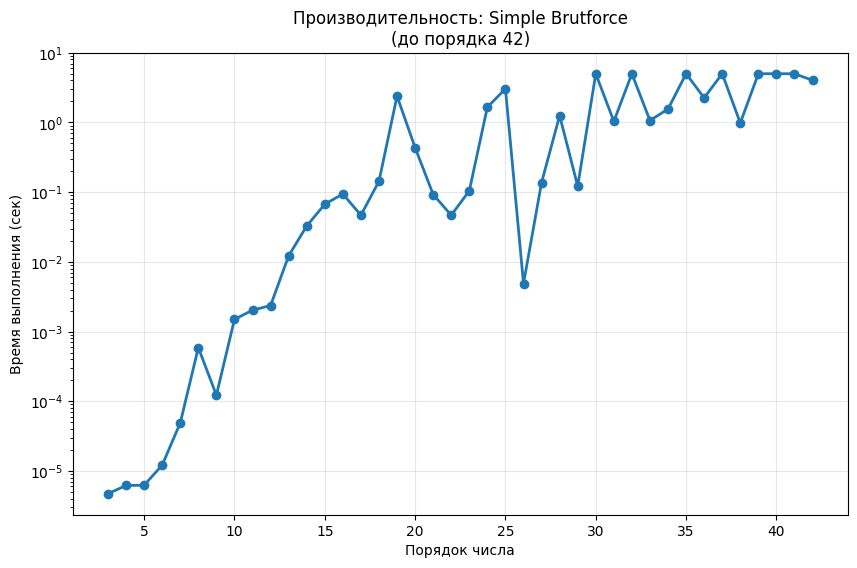

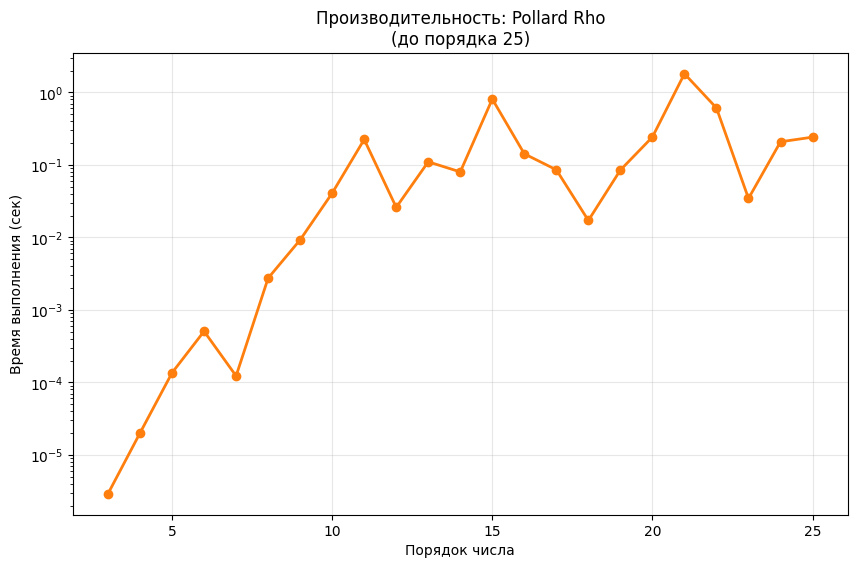

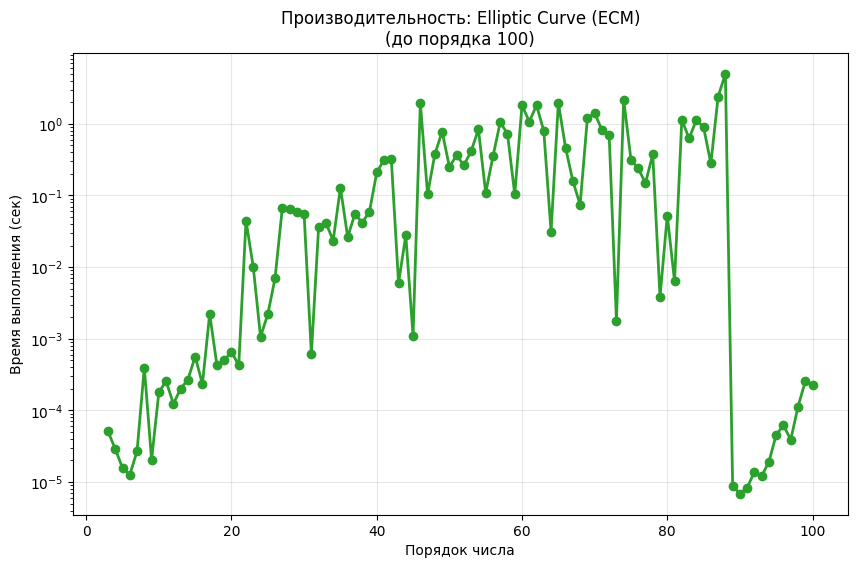

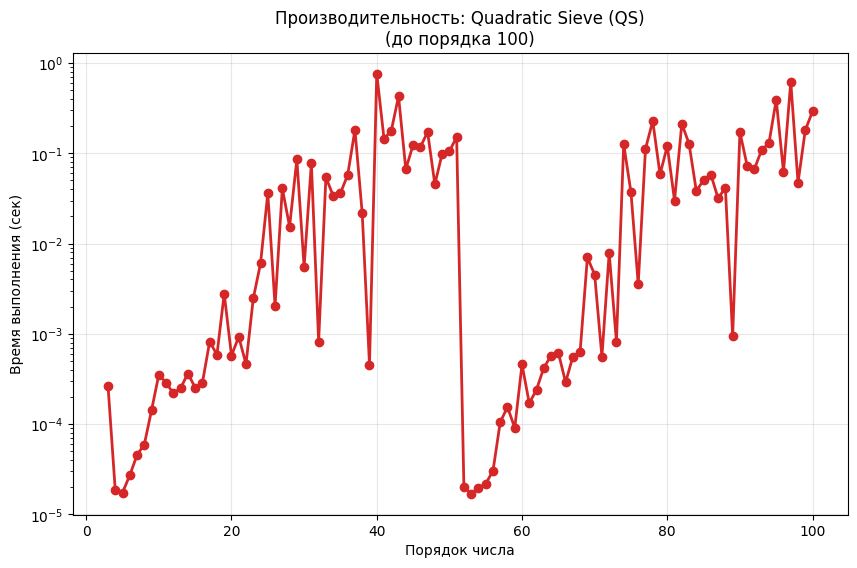

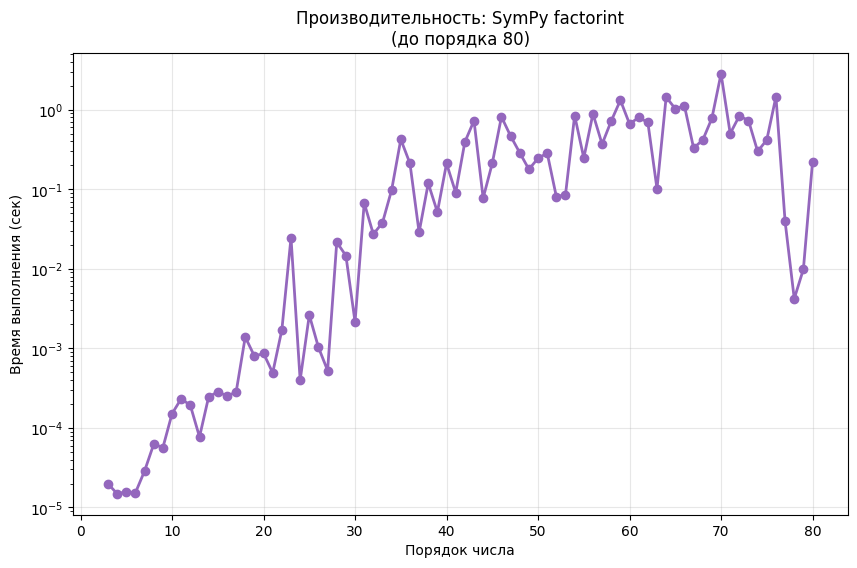

In [79]:
algorithm_colors = {
    "Simple Brutforce": '#1f77b4',
    "Pollard Rho": '#ff7f0e',
    "Elliptic Curve (ECM)": '#2ca02c',
    "Quadratic Sieve (QS)": '#d62728',
    "SymPy factorint": '#9467bd'
}

print("Построение индивидуальных графиков...")
for algo_name in ALGORITHMS.keys():
    valid_orders = []
    valid_times = []

    for i, order in enumerate(range(ORDER_RANGE[0], max_orders[algo_name]+1)):
        if i < len(results[algo_name]) and results[algo_name][i] < 20.0:
            valid_orders.append(order)
            valid_times.append(results[algo_name][i])

    if len(valid_orders) > 0:  # Строим график даже если всего 1 точка
        plt.figure(figsize=(10, 6))

        if len(valid_orders) > 1:
            plt.plot(valid_orders, valid_times, color=algorithm_colors[algo_name],
                        marker='o', linewidth=2, markersize=6)
        else:
            plt.scatter(valid_orders, valid_times, color=algorithm_colors[algo_name],
                        s=100, zorder=5)

        plt.xlabel('Порядок числа')
        plt.ylabel('Время выполнения (сек)')
        plt.title(f'Производительность: {algo_name}\n(до порядка {max_orders[algo_name]})')
        plt.grid(True, alpha=0.3)
        plt.yscale('log')

        plt.show()
        plt.close()



0 Simple Brutforce
1 Pollard Rho
2 Elliptic Curve (ECM)
3 Quadratic Sieve (QS)
4 SymPy factorint


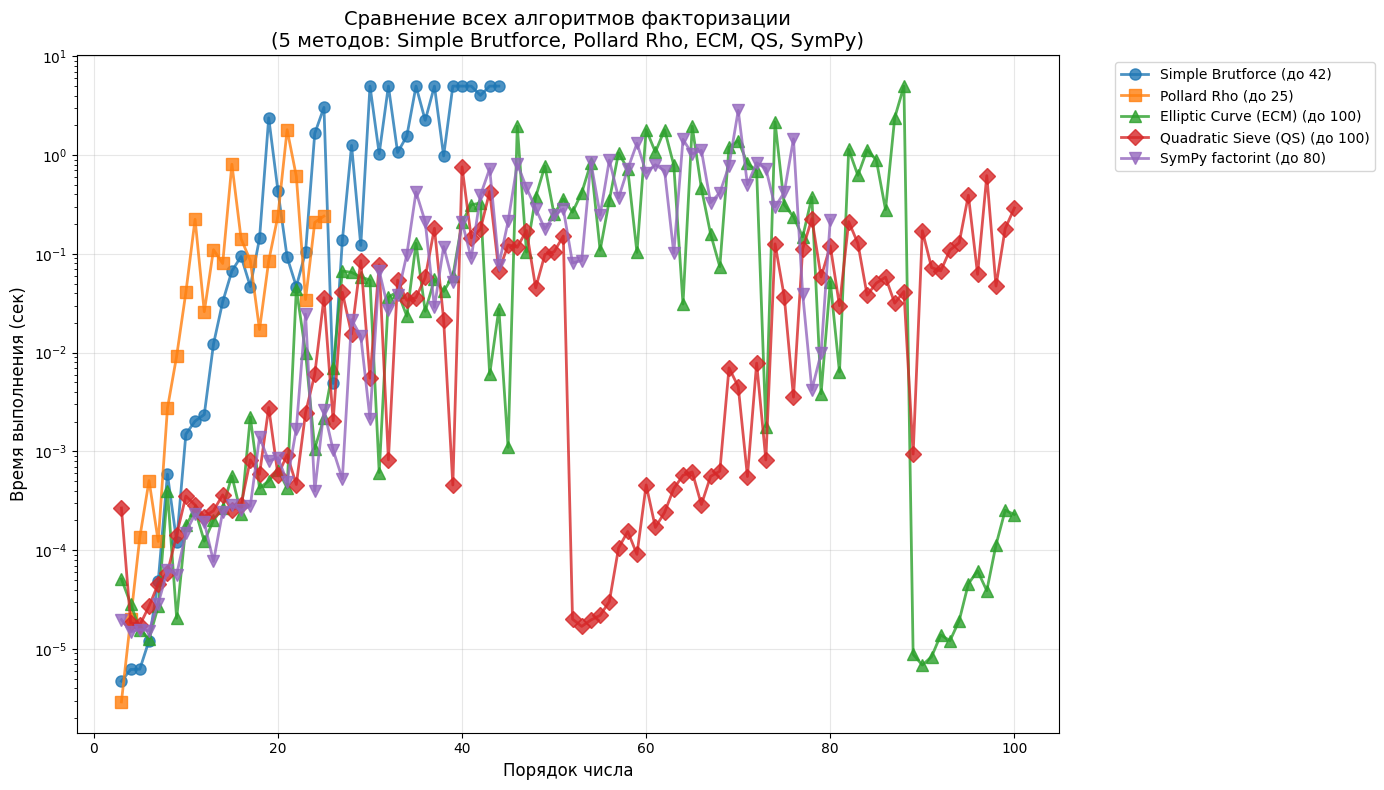

In [80]:
plt.figure(figsize=(14, 8))

markers = ['o', 's', '^', 'D', 'v']

for i, algo_name in enumerate(ALGORITHMS.keys()):
    print(i, algo_name)
    valid_orders = []
    valid_times = []

    for j, order in enumerate(range(ORDER_RANGE[0], ORDER_RANGE[1]+1)):
        if j < len(results[algo_name]) and results[algo_name][j] < 20.0:
            valid_orders.append(order)
            valid_times.append(results[algo_name][j])

    if valid_orders:
        plt.plot(valid_orders, valid_times,
                    color=algorithm_colors[algo_name],
                    marker=markers[i],
                    linewidth=2,
                    markersize=8,
                    label=f'{algo_name} (до {max_orders[algo_name]})',
                    alpha=0.8)

plt.xlabel('Порядок числа', fontsize=12)
plt.ylabel('Время выполнения (сек)', fontsize=12)
plt.title('Сравнение всех алгоритмов факторизации\n(5 методов: Simple Brutforce, Pollard Rho, ECM, QS, SymPy)',
            fontsize=14)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

plt.show()
plt.close()


In [81]:
print("ДЕТАЛЬНАЯ СВОДКА РЕЗУЛЬТАТОВ")
print("=" * 60)

sorted_results = sorted(max_orders.items(), key=lambda x: x[1], reverse=True)

print("Рейтинг алгоритмов по достигнутому порядку:")
print("-" * 50)
for i, (algo_name, max_order) in enumerate(sorted_results, 1):
    if max_order >= ORDER_RANGE[1]:
        status = f"🎯 ДОШЕЛ ДО КОНЦА ({ORDER_RANGE[1]})"
    else:
        status = f"⏹️ ОСТАНОВЛЕН на {max_order}"
    print(f"{i:2d}. {algo_name:<20} {status}")

ДЕТАЛЬНАЯ СВОДКА РЕЗУЛЬТАТОВ
Рейтинг алгоритмов по достигнутому порядку:
--------------------------------------------------
 1. Elliptic Curve (ECM) 🎯 ДОШЕЛ ДО КОНЦА (100)
 2. Quadratic Sieve (QS) 🎯 ДОШЕЛ ДО КОНЦА (100)
 3. SymPy factorint      ⏹️ ОСТАНОВЛЕН на 80
 4. Simple Brutforce     ⏹️ ОСТАНОВЛЕН на 42
 5. Pollard Rho          ⏹️ ОСТАНОВЛЕН на 25


# Лучший алгоритм

In [14]:
results = {name: [] for name in ALGORITHMS}
max_orders = {name: 0 for name in ALGORITHMS}

In [ ]:
start_time = time.time()
test_algorithm("Elliptic Curve (ECM)", orders=(3, 1000))
print(f"отработало {time.time() - start_time}")



Тестируем алгоритм: Elliptic Curve (ECM)
Порядок 3: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 4: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 5: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 6: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 7: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 8: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 9: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 10: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 11: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 12: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 13: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 14: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 15: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 16: ✓ ✓ ✓ ✓ ✓  | среднее: 0.002 сек
Порядок 17: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 18: ✓ ✓ ✓ ✓ ✓  | среднее: 0.002 сек
Порядок 19: ✓ ✓ ✓ ✓ ✓  | среднее: 0.002 сек
Порядок 20: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 21: ✓ ✓ ✓ ✓ ✓  | среднее: 0.000 сек
Порядок 22: ✓ ✓ ✓ ✓ ✓  | среднее: 0.015 сек
Порядок 23: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 сек
Порядок 24: ✓ ✓ ✓ ✓ ✓  | среднее: 0.001 се

KeyboardInterrupt: 

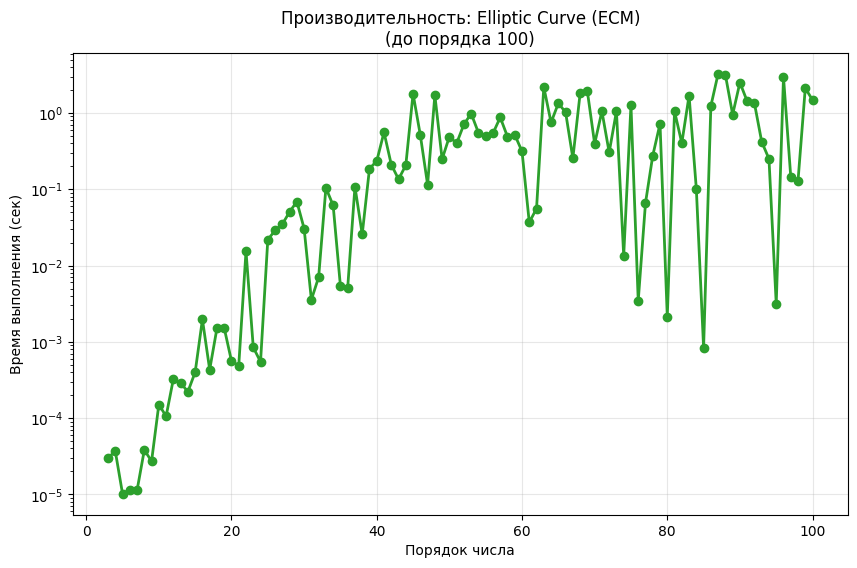

In [19]:
algorithm_colors = {
    "Elliptic Curve (ECM)": '#2ca02c',
}

algo_name = "Elliptic Curve (ECM)"
valid_orders = []
valid_times = []

for i, order in enumerate(range(ORDER_RANGE[0], max_orders[algo_name]+1)):
    if i < len(results[algo_name]) and results[algo_name][i] < 20.0:
        valid_orders.append(order)
        valid_times.append(results[algo_name][i])

if len(valid_orders) > 0:  # Строим график даже если всего 1 точка
    plt.figure(figsize=(10, 6))

    if len(valid_orders) > 1:
        plt.plot(valid_orders, valid_times, color=algorithm_colors[algo_name],
                    marker='o', linewidth=2, markersize=6)
    else:
        plt.scatter(valid_orders, valid_times, color=algorithm_colors[algo_name],
                    s=100, zorder=5)

    plt.xlabel('Порядок числа')
    plt.ylabel('Время выполнения (сек)')
    plt.title(f'Производительность: {algo_name}\n(до порядка {max_orders[algo_name]})')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    plt.show()
    plt.close()

